<a href="https://colab.research.google.com/github/DRVV/maguro.aiig/blob/main/20220215_meeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages 

In [1]:
## package installation
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

!pip install optuna

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3709    0  3709    0     0   6731      0 --:--:-- --:--:-- --:--:--  6731
100  503k  100  503k    0     0   431k      0  0:00:01  0:00:01 --:--:--  931k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3717    0  3717    0     0   8624      0 --:--:-- --:--:-- --:--:--  8604
100  406k  100  406k    0     0   398k      0  0:00:01  0:00:01 --:--:--  398k
     |████████████████████████████████| 308 kB 6.1 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 210 kB 47.4 MB/s 
     |████████████████████████████████| 75 kB 740 kB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 149 kB 45.5 MB/s 
     |█████████████████████

## Download data

In [3]:
## download data
url = f"https://raw.githubusercontent.com/DRVV/maguro.aiig/main/input/data_RF.xlsx"
!wget --no-cache --backups=1 {url}
import pandas as pd
df = pd.read_excel('data_RF.xlsx', engine='openpyxl')
print(df.shape)
df.head()

--2022-02-15 07:58:53--  https://raw.githubusercontent.com/DRVV/maguro.aiig/main/input/data_RF.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12273988 (12M) [application/octet-stream]
Saving to: ‘data_RF.xlsx’

data_RF.xlsx        100%[===================>]  11.71M  --.-KB/s    in 0.1s    

2022-02-15 07:58:53 (119 MB/s) - ‘data_RF.xlsx’ saved [12273988/12273988]

(5470, 111)


,Date,eurusd_Open,eurusd_High,eurusd_Low,eurusd_Close,EURUSD_high-low,EURUSD_close-open,EURUSD_close-open_%,EURUSD_NegativeLine,EURUSD_PositiveLine,EURUSD_posi-nega,EURUSD_lastdays,EURUSD_lastdays_up,EURUSD_lastdays_down,EURUSD_14days_RSI,usdjpy_Open,usdjpy_High,usdjpy_Low,usdjpy_Close,USDJPY_high-low,USDJPY_close-open,USDJPY_close-open_%,USDJPY_NegativeLine,USDJPY_PositiveLine,USDJPY_posi-nega,USDJPY_lastdays,USDJPY_lastdays_up,USDJPY_lastdays_down,USDJPY_14days_RSI,eurjpy_Open,eurjpy_High,eurjpy_Low,eurjpy_Close,EURJPY_high-low,EURJPY_close-open,EURJPY_close-open_%,EURJPY_NegativeLine,EURJPY_PositiveLine,EURJPY_posi-nega,EURJPY_lastdays,...,dax_Low,dax_Close,cdt_Open,cdt_High,cdt_Low,cdt_Close,platinum_Open,platinum_High,platinum_Low,platinum_Close,platinum_Volume,platinum_OpenInt,alumi_Close,vix_Close,usb2y_Close,usb10y_Open,usb10y_High,usb10y_Low,usb10y_Close,grb10y_Open,grb10y_High,grb10y_Low,grb10y_Close,itb10y_Open,itb10y_High,itb10y_Low,itb10y_Close,deb10y_Open,deb10y_High,deb10y_Low,deb10y_Close,ptd10y_Open,ptd10y_High,ptd10y_Low,ptd10y_Close,DE_US_10ySpread,GR_DE_10ySpread,IT_DE_10ySpread,PT_DE_10ySpread,Maguro
0,2000-01-03,1.0050,1.0280,1.0048,1.0262,0.0232,0.0212,0.913793,0.0002,0.0018,-0.0016,NaN,NaN,NaN,NaN,102.11,102.15,101.31,101.56,0.84,-0.55,-0.654762,0.25,0.04,0.21,NaN,NaN,NaN,NaN,102.95,104.27,102.00,104.09,2.27,1.14,0.502203,0.95,0.18,0.77,NaN,...,6720.87,6750.76,156.83,156.83,156.83,156.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.21,6.38,6.498,6.603,6.498,6.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2000-01-04,1.0240,1.0343,1.0210,1.0308,0.0133,0.0068,0.511278,0.0030,0.0035,-0.0005,0.0046,0.0046,0.000,NaN,101.46,103.27,101.40,103.25,1.87,1.79,0.957219,0.06,0.02,0.04,1.69,1.69,0.0,NaN,104.09,106.56,103.97,106.40,2.59,2.31,0.891892,0.12,0.16,-0.04,2.31,...,6510.46,6586.95,155.49,155.49,155.49,155.49,417.5,417.5,407.0,413.7,2430.0,11816.0,1615.0,27.01,6.30,6.530,6.548,6.485,6.485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2000-01-05,1.0293,1.0402,1.0280,1.0314,0.0122,0.0021,0.172131,0.0013,0.0088,-0.0075,0.0006,0.0006,0.000,NaN,103.28,104.37,102.76,104.27,1.61,0.99,0.614907,0.52,0.10,0.42,1.02,1.02,0.0,NaN,106.25,107.70,105.78,107.57,1.92,1.32,0.687500,0.47,0.13,0.34,1.17,...,6388.91,6502.07,154.91,154.91,154.91,154.91,407.5,407.5,398.0,401.9,3497.0,11377.0,1608.0,26.41,6.38,6.521,6.599,6.508,6.599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2000-01-06,1.0320,1.0414,1.0270,1.0319,0.0144,-0.0001,-0.006944,0.0049,0.0094,-0.0045,0.0005,0.0005,0.000,NaN,104.32,105.53,103.97,105.31,1.56,0.99,0.634615,0.35,0.22,0.13,1.04,1.04,0.0,NaN,107.45,109.23,107.25,108.71,1.98,1.26,0.636364,0.20,0.52,-0.32,1.14,...,6402.63,6474.92,154.99,154.99,154.99,154.99,395.5,397.9,388.1,394.0,5692.0,11038.0,1622.0,25.73,6.35,6.558,6.585,6.540,6.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,2000-01-07,1.0324,1.0330,1.0250,1.0289,0.0080,-0.0035,-0.437500,0.0039,0.0006,0.0033,-0.0030,0.0000,0.003,NaN,105.27,105.89,104.85,105.35,1.04,0.08,0.076923,0.42,0.54,-0.12,0.04,0.04,0.0,NaN,108.74,109.01,107.77,108.36,1.24,-0.38,-0.306452,0.59,0.27,0.32,-0.35,...,6470.14,6780.96,154.75,154.75,154.75,154.75,394.0,399.5,394.0,396.0,967.0,10085.0,1638.0,21.72,6.31,6.545,6.595,6.504,6.504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Import packages

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.ticker as ticker

# インストール方法 https://tkstock.site/2018/08/22/post-593/
import talib as ta

## 評価関数

In [5]:
def win_loss(Y_test, pred):
    # Series型のデータをデータフレーム化
    test_y2 = pd.DataFrame(Y_test)
    # 予測結果を格納
    test_y2['pred'] = pred

    # 混同行列の各セルを定義
    m1 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==1)])
    m2 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==0)])
    m3 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==-1)])
    m4 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==1)])
    m5 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==0)])
    m6 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==-1)])
    m7 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==1)])
    m8 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==0)])
    m9 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==-1)])

    #　Total取引回数、大勝率、大敗率、の計算
    try:
        mall=m1+m2+m3+m4+m5+m6+m7+m8+m9
        ma=m1+m3+m4+m6+m7+m9
        mb=(m1+m9)/ma
        mc=(m3+m7)/ma
        win_loss_ratio = mb/mc
    except ZeroDivisionError:
        win_loss_ratio = 0
        
    # 各種モデル評価指標出力
    return win_loss_ratio

## 欠損処理

### 欠損率

In [7]:
null_count = df.isnull().sum()
null_rate = null_count / len(df)

null_table = pd.DataFrame({
    '欠損行数': null_count,
    '欠損率': null_rate
})

print('total length', df.shape)
null_table.sort_values(by='欠損率', ascending=False).head(30)


total length (5470, 111)


,欠損行数,欠損率
PT_DE_10ySpread,1754,0.320658
ptd10y_Close,1744,0.318830
ptd10y_Low,1744,0.318830
ptd10y_High,1744,0.318830
ptd10y_Open,1744,0.318830
DE_US_10ySpread,1721,0.314625
GR_DE_10ySpread,1627,0.297441
grb10y_Low,1616,0.295430
grb10y_High,1616,0.295430
grb10y_Open,1616,0.295430


### 欠損補完

In [12]:
# # とりあえず欠損行を全削除
df_drop = df.dropna(how="any")
print(df_drop.shape)

(3129, 111)


In [11]:
df.interpolate(limit_direction='forward', axis=0, method='ffill')


,Date,eurusd_Open,eurusd_High,eurusd_Low,eurusd_Close,EURUSD_high-low,EURUSD_close-open,EURUSD_close-open_%,EURUSD_NegativeLine,EURUSD_PositiveLine,EURUSD_posi-nega,EURUSD_lastdays,EURUSD_lastdays_up,EURUSD_lastdays_down,EURUSD_14days_RSI,usdjpy_Open,usdjpy_High,usdjpy_Low,usdjpy_Close,USDJPY_high-low,USDJPY_close-open,USDJPY_close-open_%,USDJPY_NegativeLine,USDJPY_PositiveLine,USDJPY_posi-nega,USDJPY_lastdays,USDJPY_lastdays_up,USDJPY_lastdays_down,USDJPY_14days_RSI,eurjpy_Open,eurjpy_High,eurjpy_Low,eurjpy_Close,EURJPY_high-low,EURJPY_close-open,EURJPY_close-open_%,EURJPY_NegativeLine,EURJPY_PositiveLine,EURJPY_posi-nega,EURJPY_lastdays,...,dax_Low,dax_Close,cdt_Open,cdt_High,cdt_Low,cdt_Close,platinum_Open,platinum_High,platinum_Low,platinum_Close,platinum_Volume,platinum_OpenInt,alumi_Close,vix_Close,usb2y_Close,usb10y_Open,usb10y_High,usb10y_Low,usb10y_Close,grb10y_Open,grb10y_High,grb10y_Low,grb10y_Close,itb10y_Open,itb10y_High,itb10y_Low,itb10y_Close,deb10y_Open,deb10y_High,deb10y_Low,deb10y_Close,ptd10y_Open,ptd10y_High,ptd10y_Low,ptd10y_Close,DE_US_10ySpread,GR_DE_10ySpread,IT_DE_10ySpread,PT_DE_10ySpread,Maguro
0,2000-01-03,1.00500,1.02800,1.00480,1.02620,0.02320,0.02120,0.913793,0.00020,0.00180,-0.00160,NaN,NaN,NaN,NaN,102.110,102.150,101.310,101.560,0.840,-0.550,-0.654762,0.250,0.040,0.210,NaN,NaN,NaN,NaN,102.950,104.270,102.000,104.090,2.270,1.140,0.502203,0.950,0.180,0.770,NaN,...,6720.87,6750.76,156.8300,156.8300,156.8300,156.8300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.21,6.380,6.498,6.603,6.498,6.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2000-01-04,1.02400,1.03430,1.02100,1.03080,0.01330,0.00680,0.511278,0.00300,0.00350,-0.00050,0.00460,0.00460,0.00000,NaN,101.460,103.270,101.400,103.250,1.870,1.790,0.957219,0.060,0.020,0.040,1.690,1.690,0.0,NaN,104.090,106.560,103.970,106.400,2.590,2.310,0.891892,0.120,0.160,-0.040,2.310,...,6510.46,6586.95,155.4900,155.4900,155.4900,155.4900,417.5,417.5,407.0,413.7,2430.0,11816.0,1615.0,27.01,6.300,6.530,6.548,6.485,6.485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2000-01-05,1.02930,1.04020,1.02800,1.03140,0.01220,0.00210,0.172131,0.00130,0.00880,-0.00750,0.00060,0.00060,0.00000,NaN,103.280,104.370,102.760,104.270,1.610,0.990,0.614907,0.520,0.100,0.420,1.020,1.020,0.0,NaN,106.250,107.700,105.780,107.570,1.920,1.320,0.687500,0.470,0.130,0.340,1.170,...,6388.91,6502.07,154.9100,154.9100,154.9100,154.9100,407.5,407.5,398.0,401.9,3497.0,11377.0,1608.0,26.41,6.380,6.521,6.599,6.508,6.599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2000-01-06,1.03200,1.04140,1.02700,1.03190,0.01440,-0.00010,-0.006944,0.00490,0.00940,-0.00450,0.00050,0.00050,0.00000,NaN,104.320,105.530,103.970,105.310,1.560,0.990,0.634615,0.350,0.220,0.130,1.040,1.040,0.0,NaN,107.450,109.230,107.250,108.710,1.980,1.260,0.636364,0.200,0.520,-0.320,1.140,...,6402.63,6474.92,154.9900,154.9900,154.9900,154.9900,395.5,397.9,388.1,394.0,5692.0,11038.0,1622.0,25.73,6.350,6.558,6.585,6.540,6.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,2000-01-07,1.03240,1.03300,1.02500,1.02890,0.00800,-0.00350,-0.437500,0.00390,0.00060,0.00330,-0.00300,0.00000,0.00300,NaN,105.270,105.890,104.850,105.350,1.040,0.080,0.076923,0.420,0.540,-0.120,0.040,0.040,0.0,NaN,108.740,109.010,107.770,108.360,1.240,-0.380,-0.306452,0.590,0.270,0.320,-0.350,...,6470.14,6780.96,154.7500,154.7500,154.7500,154.7500,394.0,399.5,394.0,396.0,967.0,10085.0,1638.0,21.72,6.310,6.545,6.595,6.504,6.504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54

In [10]:
# NULLを過去の値で補完
df_drop = df.interpolate(limit_direction='forward', axis=0, method='ffill').dropna(how="any")
print(df_drop.shape)

(3772, 111)


## 特徴量作成/加工
- テクニカル指標の追加
- 変数ごとに有効そうな統計量作成
- 過去の実績値の差分（1週間前との価格差分など）
- 日付の加工（祝日・曜日など）

### テクニカル指標

In [13]:
# テクニカル指標を計算
def calc_technical_indicators(Date, high, low, close, prefix):
    df_x = pd.DataFrame({'Date':Date})

    # 単純移動平均
    df_x['{}_sma5'.format(prefix)] = ta.SMA(close, timeperiod=5)
    df_x['{}_sma25'.format(prefix)] = ta.SMA(close, timeperiod=25)
    df_x['{}_sma50'.format(prefix)] = ta.SMA(close, timeperiod=50)
    df_x['{}_sma200'.format(prefix)] = ta.SMA(close, timeperiod=200)

    # 指数平滑化移動平均
    df_x['{}_ema12'.format(prefix)] = ta.EMA(close, timeperiod=12)
    df_x['{}_ema20'.format(prefix)] = ta.EMA(close, timeperiod=20)
    df_x['{}_ema50'.format(prefix)] = ta.EMA(close, timeperiod=50)
    df_x['{}_ema200'.format(prefix)] = ta.EMA(close, timeperiod=200)

    # MACD (Moving Average Convergence/Divergence)
    macd, macd_sig, macd_hist = ta.MACD(close, fastperiod=12, 
                                            slowperiod=26,
                                            signalperiod=9)
    df_x['{}_macd'.format(prefix)] = macd
    df_x['{}_macd_sig'.format(prefix)] = macd_sig
    df_x['{}_macd_hist'.format(prefix)] = macd_hist

    # RSI (Relative Strength Index)
    df_x['{}_rsi_long'.format(prefix)] = ta.RSI(close, timeperiod=14)
    df_x['{}_rsi_short'.format(prefix)] = ta.RSI(close, timeperiod=7)

    # WILLR (Williams' %R)
    df_x['{}_willr'.format(prefix)] = ta.WILLR(high, low, close, timeperiod=14)

    # Stochastic (STOCH)
    slowk, slowd = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3,
                            slowk_matype=0, slowd_period=3, slowd_matype=0)

    df_x['{}_slowk'.format(prefix)] = slowk
    df_x['{}_slowd'.format(prefix)] = slowd

    # Bolinger Bands (BBANDS)
    u_band, m_band, l_band = ta.BBANDS(close, timeperiod=5,
                                       nbdevup=2, nbdevdn=2, matype=0)

    df_x['{}_u_band'.format(prefix)] = u_band
    df_x['{}_m_band'.format(prefix)] = m_band
    df_x['{}_l_band'.format(prefix)] = l_band

    # ADX, DI+ and DI-
    df_x['{}_adx'.format(prefix)] = ta.ADX(high, low, close,timeperiod=14)

    df_x['{}_DI_plus'.format(prefix)] = ta.PLUS_DI(high, low, close, timeperiod=14)
    df_x['{}_DI_minus'.format(prefix)] = ta.MINUS_DI(high, low, close, timeperiod=14)

    return df_x

In [14]:
# テクニカル指標の計算対象
Date = np.array(df_drop['Date']) 
high = np.array(df_drop['eurusd_High'])
low = np.array(df_drop['eurusd_Low'])
close = np.array(df_drop['eurusd_Close']) 
prefix = 'eurusd'

# テクニカル指標追加
df_technical_indicators = calc_technical_indicators(Date, high, low, close, prefix)
df_drop_add = pd.merge(df_drop
            ,df_technical_indicators
            ,on='Date'
            ,how='left').dropna(how="any")
print(df_drop_add.shape)

(2930, 133)


###  日付の加工

In [15]:
# 日付の年月、曜日（月曜が0, 日曜が6）情報の抽出
# ダミー変数へ変換
df_drop_add =df_drop_add.assign(
#             year=df_drop['Date'].dt.year
            month=df_drop['Date'].dt.month
            ,weekday=df_drop['Date'].dt.dayofweek
            ).pipe(lambda df: pd.get_dummies(df, columns=['month','weekday']))

### 正規化/標準化

### 特徴量の選定
モデルに使う特徴量を決める

NameError: name 'df_tr' is not defined

## バリデーション
時系列データでランダム分割する場合、翌日のデータがtrainに混ざることもあり過学習しやすいため、時系列の並びを維持したままバリデーションする

In [16]:
split_day = dt.datetime(2020,1,1)
df_tr = df_drop_add[df_drop_add['Date'] < split_day]
df_te = df_drop_add[df_drop_add['Date'] >= split_day]

X_train = df_tr.drop('Maguro', axis=1)
Y_train = df_tr['Maguro']

X_test = df_te.drop('Maguro', axis=1)
Y_test = df_te['Maguro']

In [17]:
# # train,testを分割
# X_train, X_test, Y_train, Y_test = train_test_split(df_drop_add.drop('Maguro', axis=1), df_drop_add["Maguro"]
#                                                     ,shuffle=False
#                                                     ,train_size=0.6)

### trainとtestの範囲可視化

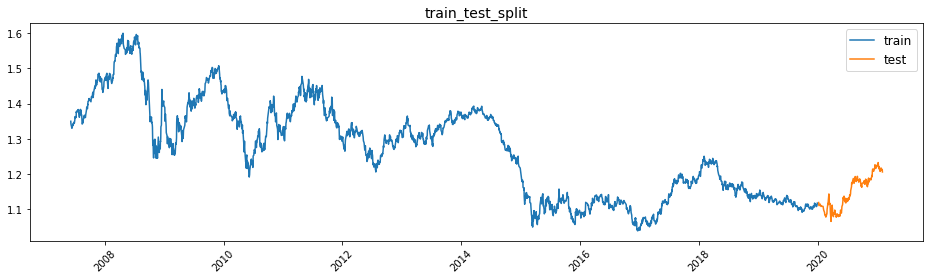

In [18]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(X_train['Date'], X_train['eurusd_Open'], label='train')
ax.plot(X_test['Date'], X_test['eurusd_Open'], label='test')
ax.legend(fontsize=12)
ax.set_title('train_test_split', fontsize=14)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
ax.xaxis.set_tick_params(rotation=45)

##  モデル作成

In [19]:
# Date削除
X_train.drop('Date', axis=1, inplace=True)
X_test.drop('Date', axis=1, inplace=True)

### デフォルトのパラメータのモデル（ベースライン）

In [30]:
seed = 84
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, Y_train)
pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, pred)))
a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
maguro = a+i
print('maguro検出数: {}'.format(maguro))
print('Big Win/Big Loss Ratio: {}'.format(win_loss(Y_test, pred)))

Accuracy: 0.35555555555555557
maguro検出数: 30
Big Win/Big Loss Ratio: 1.5789473684210527


# **Point 1. 出力の分布を確認, postprocessingを判断する**

In [31]:
pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  0,  1,  1,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0, -1,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,
       -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1,  0,
       -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1, -1,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,
       -1,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1,  0, -1, -1, -1, -1,
       -1, -1,  0,  0])

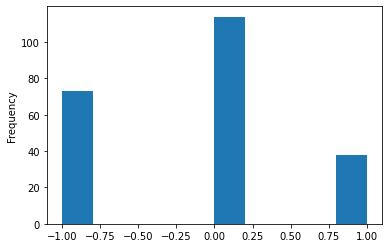

In [32]:
pd.Series(pred).plot.hist()

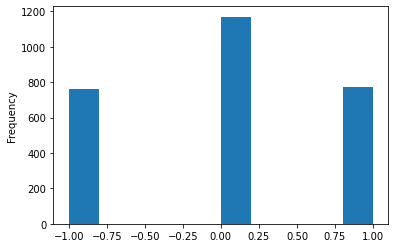

In [33]:
pd.Series(Y_train).plot.hist()

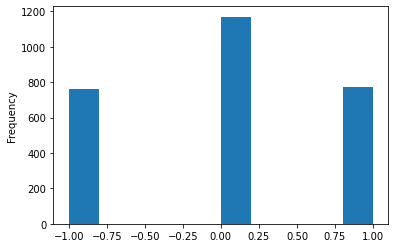

In [38]:
pd.Series(model.predict(X_train)).plot.hist()

# 2. モデルを変えてみる

In [40]:
import lightgbm
model2 = lightgbm.LGBMClassifier()
model2.fit(X_train, Y_train)
pred2 = model2.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, pred2)))
a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred2).ravel()
maguro = a+i
print('maguro検出数: {}'.format(maguro))
print('Big Win/Big Loss Ratio: {}'.format(win_loss(Y_test, pred2)))

Accuracy: 0.5022222222222222
maguro検出数: 8
Big Win/Big Loss Ratio: 4.0


### optunaを使ったパラメーターチューニング

In [ ]:
def objective(trial):
    '''
    trial:set of hyperparameter    
    '''

    # hypyer param（いろいろ試す）
    max_depth = trial.suggest_int('max_depth', 3, 10) 
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'auto', 'log2'])
    min_samples_split = trial.suggest_int('min_samples_split',2,5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
#     bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,1000)

    # model
    model = RandomForestClassifier(max_depth=max_depth,
                                  n_estimators=1000,
                                  max_features=max_features,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  n_jobs=-1,
                                  verbose=-1 #学習情報を非表示
                                  )

    # fit
    model.fit(X_train, Y_train)

    # eva
    pred = model.predict(X_test)
    # score = accuracy_score(Y_test, pred) 

#     マグロを検出した件数が最も多いパラメータを評価
#     a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
#     maguro = a+i
#     return maguro

    # Big Win/Big Loss Ratioが最も大きいパラメータを評価
    win_loss_ratio = win_loss(Y_test, pred)
    return win_loss_ratio

# パラメーターチューニングを実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=17)
                            ,direction='maximize')

study.optimize(func=objective # 実行する関数
               ,n_trials=30 # 試行回数
               ,timeout=30 # 与えられた秒数後に学習を中止 default=None
               ,n_jobs=-1 # 並列実行するjob数
               
              )

print('ベストパラメータ: {}'.format(study.best_params))
# print('maguro検出数: {}'.format(study.best_value))
print('Big Win/Big Loss Ratio: {}'.format(study.best_value))

best_param = study.best_params

[I 2021-04-01 20:37:29,076] A new study created in memory with name: no-name-5e55a9fa-6165-4f00-9b23-8ada0ea440e4
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed

ベストパラメータ: {'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 1}
Big Win/Big Loss Ratio: 1.0


In [ ]:
# ベストパラメータにてモデル作成
seed = 17
model = RandomForestClassifier(**best_param, random_state=seed)
model.fit(X_train, Y_train)
pred = model.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(Y_test, pred)))
a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
maguro = a+i
print('maguro検出数: {}'.format(maguro))
print('Big Win/Big Loss Ratio: {}'.format(win_loss(Y_test, pred)))

Accuracy: 0.5124555160142349
maguro検出数: 8
Big Win/Big Loss Ratio: 8.0


In [ ]:
# モデル保存
pd.to_pickle(model, '../output/rf.pkl')

## 精度評価

### 混同行列

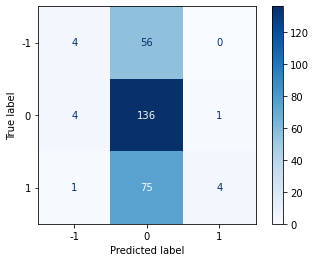

In [ ]:
plot_confusion_matrix(model, X_test, Y_test,cmap='Blues')

### win/loss

In [ ]:
# Series型のデータをデータフレーム化
test_y2 = pd.DataFrame(Y_test)
# 予測結果を格納
test_y2['pred'] = model.predict(X_test)

# 混同行列の各セルを定義
m1 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==1)])
m2 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==0)])
m3 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==-1)])
m4 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==1)])
m5 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==0)])
m6 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==-1)])
m7 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==1)])
m8 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==0)])
m9 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==-1)])

#　Total取引回数、大勝率、大敗率、の計算
mall=m1+m2+m3+m4+m5+m6+m7+m8+m9
ma=m1+m3+m4+m6+m7+m9
mb=(m1+m9)/ma
mc=(m3+m7)/ma

# 各種モデル評価指標出力
print('＜基本情報＞')
print('Total days',mall)
print('Total Trade times',ma)
print('Total Trade frequency',ma/mall)
print('Trade times per year',ma/(mall/250))
print('Trade times per month',250*ma/mall/12)
print('Trade times per week',250*ma/mall/12/4)
print('Trade times per day',250*ma/mall/12/20)
print('＜勝敗割合＞')
print('Big Win rate',mb)
print('Big Loss rate',mc)
print('Small trade',(m4+m6)/ma)
print('Big Win/Big Loss Ratio',mb/mc)

＜基本情報＞
Total days 281
Total Trade times 14
Total Trade frequency 0.0498220640569395
Trade times per year 12.455516014234874
Trade times per month 1.0379596678529064
Trade times per week 0.2594899169632266
Trade times per day 0.05189798339264532
＜勝敗割合＞
Big Win rate 0.5714285714285714
Big Loss rate 0.07142857142857142
Small trade 0.35714285714285715
Big Win/Big Loss Ratio 8.0


### トレードのシミュレーション

In [ ]:
def trade_simulation(dfx,leverage,start_balance):
    i = 0
    for index,item in dfx.iterrows():
        # 1万EUR（1枚）取引に必要な証拠金
        dfx.loc[index,'margin_per_eur'] = item['eurusd_Close']*item['usdjpy_Close']*10000/leverage

        # 残高
        if i <= 1:
            dfx.loc[index,'balance'] = start_balance 
        else:
            dfx.loc[index,'balance'] = dfx.loc[index-1,'balance'] + dfx.loc[index-1,'profit_loss']

        # 枚数
        num = dfx.loc[index,'balance']/2/dfx.loc[index,'margin_per_eur']
        if num>100:
            num = 100
        dfx.loc[index,'num']  = num

        # 必要証拠金
        dfx.loc[index,'margin']  = dfx.loc[index,'margin_per_eur']*dfx.loc[index,'num']

        # ポジションメイク後投資余力
        dfx.loc[index,'capacity']  = dfx.loc[index,'balance']-dfx.loc[index,'margin']

        # レート変動耐性
        dfx.loc[index,'rate_fluctuation_tolerance'] = dfx.loc[index,'capacity']/(dfx.loc[index,'num']*10000)

        # 損益
        if i <= 1:
            dfx.loc[index,'profit_loss'] = 0 
        else:
            dfx.loc[index,'profit_loss'] = dfx.loc[index-2,'pred']*(dfx.loc[index,'eurusd_Close']-dfx.loc[index-2,'eurusd_Close'])*dfx.loc[index-2,'num']*10000*dfx.loc[index,'usdjpy_Close']

        i = i+1
    return dfx

In [ ]:
## testデータの予測結果に説明変数を結合
# Series型のデータをデータフレーム化
test_y2 = pd.DataFrame(Y_test)
test_y2['pred'] = model.predict(X_test)

# 予測結果保存
col = ['Date','eurusd_Open', 'eurusd_High', 'eurusd_Low', 'eurusd_Close', 'usdjpy_Close', 'Maguro', 'pred']
df_test_result = pd.merge(df_drop_add, test_y2['pred'], left_index=True, right_index=True)[col]


## trainデータの予測結果に説明変数を結合
# Series型のデータをデータフレーム化
train_y2 = pd.DataFrame(Y_train)
train_y2['pred'] = model.predict(X_train)

# 予測結果保存
col = ['Date','eurusd_Open', 'eurusd_High', 'eurusd_Low', 'eurusd_Close', 'usdjpy_Close', 'Maguro', 'pred']
df_train_result = pd.merge(df_drop_add, train_y2['pred'], left_index=True, right_index=True)[col]


#### Back test

初日: 2007-04-20 00:00:00
最終日: 2021-02-02 00:00:00
最終日時点の残高: 1209551552
儲け: 1208551552


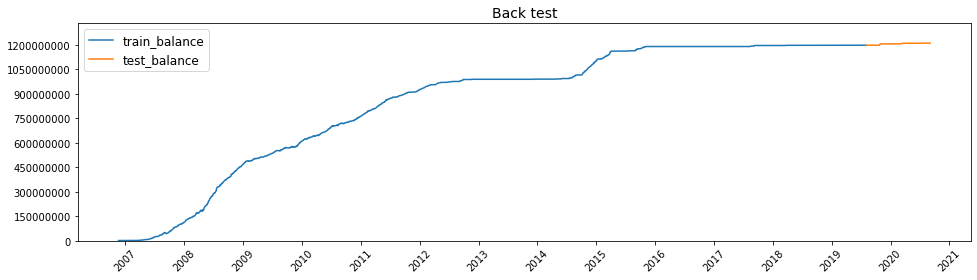

In [ ]:
# レバレッジ倍数
leverage = 25
# スタート時の残高
start_balance = 1000000

# 損益計算
df_train_result['is_train'] = True
df_test_result['is_train'] = False
df_concat = pd.concat([df_train_result, df_test_result])

df_back_test = trade_simulation(df_concat,leverage,start_balance)
df_back_test.to_csv('../output/df_back_test.csv', encoding='cp932',index=True)

# Back test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_concat[df_back_test['is_train']]['Date'], df_back_test[df_back_test['is_train']]['balance'], label='train_balance')
ax.plot(df_concat[~df_back_test['is_train']]['Date'], df_back_test[~df_back_test['is_train']]['balance'], label='test_balance')
ax.legend(fontsize=12)
ax.set_title('Back test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_back_test['balance'].max() + df_back_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, df_back_test['balance'].max() + 1000000, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_back_test.iloc[0]['Date']))
print('最終日: {}'.format(df_back_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)-start_balance))

#### Forward test

初日: 2020-01-02 00:00:00
最終日: 2021-02-02 00:00:00
最終日時点の残高: 2857674
儲け: 1857674


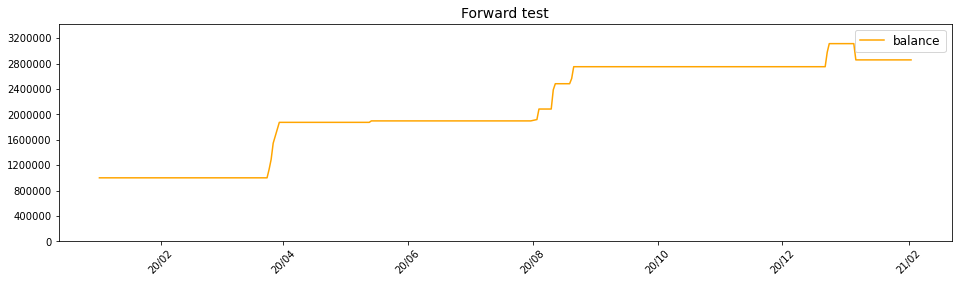

In [ ]:
# レバレッジ倍数
leverage = 25
# スタート時の残高
start_balance = 1000000
# 損益計算
df_forward_test = trade_simulation(df_test_result,leverage,start_balance)
df_forward_test.to_csv('../output/df_forward_test.csv', encoding='cp932',index=True)

# Forward test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_forward_test['Date'], df_forward_test['balance'], label='balance', color='orange')
ax.legend(fontsize=12)
ax.set_title('Forward test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_forward_test['balance'].max() + df_forward_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, 5000001, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_forward_test.iloc[0]['Date']))
print('最終日: {}'.format(df_forward_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)-start_balance))

### feature_importance

,feature_names,feature_importance
100,deb10y_Close,0.015063
71,dax_Close,0.014803
69,dax_High,0.014736
43,dow_High,0.014284
45,dow_Close,0.014283
42,dow_Open,0.013799
97,deb10y_Open,0.011759
105,DE_US_10ySpread,0.011526
83,vix_Close,0.011343
89,grb10y_Open,0.011067


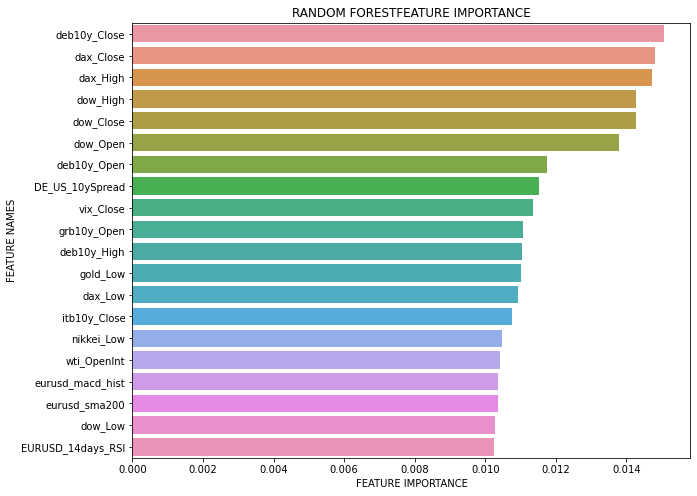

In [ ]:
def plot_feature_importance(importance,names):
    
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    return fi_df

# 重要な変数トップ20を取得
fi_df = plot_feature_importance(model.feature_importances_,X_train.columns)
fi_df = fi_df.head(20)

# Define size of bar plot
plt.figure(figsize=(10,8))
# Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Add chart labels
plt.title('RANDOM FOREST' + 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

display(fi_df)